In [2]:
####### Calculation packages
####### 

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.linalg import pinv
import math
import random

####### Plotting packages
####### 

import seaborn as sns
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib.colors import LogNorm
from matplotlib.ticker import FixedLocator, FixedFormatter, FormatStrFormatter

####### Formatting packages
####### 

import warnings
from time import time as tm
#from google.colab import files

####### self-defined packages
####### 
from HelperFuns import *

np.random.seed(2023)

####### Plotting
sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
####### 

In [3]:
# First-time run simulation: True!
# Use stored simulation data: False!
runsims = True

# Setup

In [4]:
## this is for nD cost function
def W_nd_Costfun(Weight, G_nd, X_nd, r_hat_nd):
    A = inv(inv(G_nd) - Weight)
    return np.sum((A@X_nd-r_hat_nd)**2)/m

def A_nd_Costfun(A, X_nd, r_hat_nd):
    return np.sum((A@X_nd-r_hat_nd)**2)/m 

In [5]:
n = 200              # network size N = 200
G_nd= np.eye(n)      # connectivity matrix with diagnal = 1
invG_nd= inv(G_nd)   # to avoid multiple inverse calculations
m = 100#*5           # sample size (m>n, under-parameterized system)
sigma_x = .1
sigma_r = 0.01
X_nd = sigma_x*np.random.randn(n,m)

scale_stability = 0.5   # Girko's circular law
W_hat_nd = scale_stability*np.random.randn(n,n)*np.sqrt(1/n) # unit circle
plot_W_hat = np.linalg.eigvals(W_hat_nd)

## see how eigenvalue of W_hat spreads, notice that it's within a scaled unit circle
# plt.figure
# plt.scatter(np.real(plot_W_hat), np.imag(plot_W_hat))
# plt.show()

A_hat_nd = inv(invG_nd - W_hat_nd) 
r_hat_nd = A_hat_nd@X_nd + sigma_r*np.random.randn(n,m) 
Jacob_nd = -np.eye(n)+G_nd@W_hat_nd

## get optimal
A_star = r_hat_nd@X_nd.T@(inv(X_nd@X_nd.T)) # Underline minimizer 
A_star_psudo = r_hat_nd@pinv(X_nd)  # from psudo inverse

W_star = invG_nd-inv(A_star) # Underline minimizer 
W_star_psudo = invG_nd-inv(A_star_psudo) # from A+
W_star_try = (r_hat_nd-X_nd)@pinv(r_hat_nd) # self-derive

print(A_nd_Costfun(A_hat_nd, X_nd, r_hat_nd),
      A_nd_Costfun(A_star, X_nd, r_hat_nd),
      A_nd_Costfun(A_star_psudo, X_nd, r_hat_nd))

print(W_nd_Costfun(W_hat_nd, G_nd,X_nd, r_hat_nd),
      W_nd_Costfun(W_star, G_nd, X_nd, r_hat_nd),
      W_nd_Costfun(W_star_psudo, G_nd, X_nd, r_hat_nd),
      W_nd_Costfun(W_star_try,G_nd, X_nd, r_hat_nd))

# perturb several traces of W
num_paris = 10
perturb = 5#10
W1_set = perturb*scale_stability*np.random.randn(num_paris,n,n)*np.sqrt(1/n)

## loss trace along (-1,1) segment,w
w = np.arange(-1.01, 1+0.01, 0.01) 
CostW_nd = np.zeros((num_paris,len(w)))
CostA_nd = np.zeros((num_paris,len(w)))

for k in range(num_paris):
#     W0 = W_hat_nd 
    W0 = W_star_try
    W1 = W1_set[k]
#     A0 = A_hat_nd 
    A0 = A_star_psudo
    A1 = inv(invG_nd-W1) 
    for i in range(len(w)):
        CostW_nd[k,i]=W_nd_Costfun(w[i]*W1 + W0, G_nd, X_nd, r_hat_nd)
        CostA_nd[k,i]=A_nd_Costfun(w[i]*A1 + A0, X_nd, r_hat_nd)
        

0.019916381505374798 1763.41569813652 1.103039248297159e-29
0.019916381505374798 1763.415698136522 7.273213052584765 5.998227578025878e-30


In [6]:
def CostValue_nd(num_paris, W_star_try, A_star_psudo, W1_set, W2_set, G_nd):
    x = y = np.arange(-1.01, 1 + 0.01, 0.01)
    CostW_nd_land = np.zeros((num_paris, len(x), len(y)))
    CostA_nd_land = np.zeros((num_paris, len(x), len(y)))
    for k in range(num_paris):
    # for k in range(1):
        W0 = W_star_try
        W1 = W1_set[k]
        W2 = W2_set[k]

        A0 = A_star_psudo
        A1 = inv(inv(G_nd) - W1)
        A2 = inv(inv(G_nd) - W2)
        for i in range(len(x)):
            for j in range((len(y))):
                CostW_nd_land[k, i, j] = W_nd_Costfun(((x[i] * W1 + y[j] * W2) + W0), G_nd, X_nd, r_hat_nd)
                CostA_nd_land[k, i, j] = A_nd_Costfun(((x[i] * A1 + y[j] * A2) + A0), X_nd, r_hat_nd)

    return (CostW_nd_land, CostA_nd_land)



x = y = np.arange(-1.01, 1+0.01, 0.01)
X, Y = np.meshgrid(x, y)
W1_set = perturb*scale_stability*np.random.randn(num_paris,n,n)*np.sqrt(1/n) # already ran
W2_set = perturb*scale_stability*np.random.randn(num_paris,n,n)*np.sqrt(1/n)

CostW_nd_land = np.zeros((num_paris,len(x), len(y)))
CostA_nd_land = np.zeros((num_paris, len(x), len(y)))
for k in range(1):
    W0 = W_star_try
    W1 = W1_set[k]
    W2 = W2_set[k]

    A0 = A_star_psudo
    A1 = inv(invG_nd-W1) 
    A2 = inv(invG_nd-W2) 
    for i in range(len(x)):
        for j in range((len(y))):
            CostW_nd_land[k,i,j]=W_nd_Costfun((x[i]*W1 + y[j]*W2)+W0, G_nd, X_nd, r_hat_nd) # maybe 1/sqrt(2) not the 1/2
            CostA_nd_land[k,i,j]=A_nd_Costfun((x[i]*A1 + y[j]*A2)+A0, X_nd, r_hat_nd)


<ipython-input-14-9f7ee4805a4e>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c=ax.pcolormesh(X,Y,Z1,cmap='hot',vmin=minZ, vmax=maxZ)
<ipython-input-14-9f7ee4805a4e>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['250','500','750','1000+'])
<ipython-input-14-9f7ee4805a4e>:116: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c=ax.pcolormesh(X,Y,Z1,cmap='hot',norm=LogNorm(vmin=minZ, vmax=maxZ))
<ipyt

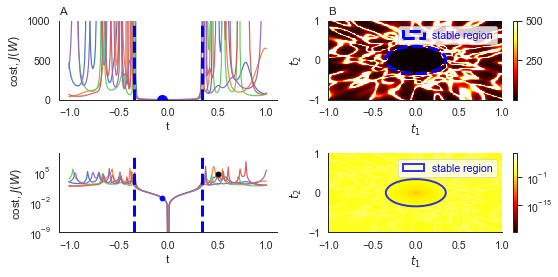

In [14]:
sns.set(context='paper',style='white',font_scale=1.2)
sns.set_palette('muted')

# fig = tools.make_subplots(rows=2, cols=2 ,print_grid=False)
## plotting the 1D landscape
# fig = plt.subplots(figsize = (8,4))
fig = plt.figure(figsize=(8, 4))
fig.add_subplot(221)

# plt.subplots(figsize=(8,5))
# plt.subplot(2,2,1)
x = w
y1 = CostW_nd[0,:]
y2 = CostW_nd[1,:]
y3 = CostW_nd[3,:]
y4 = CostW_nd[4,:]
y5 = CostW_nd[5,:]

plt.ylim(0,1000)
plt.plot(x,y1,label='trace1')
plt.plot(x,y2,label='trace2')
plt.plot(x,y3,label='trace3')
plt.plot(x,y4,label='trace4')
plt.plot(x,y5,label='trace5')

# plt.plot(0, W_nd_Costfun(W_star_try, G_nd, X_nd, r_hat_nd), '*', color = "red", markersize=15)
plt.plot(w[100-5], W_nd_Costfun((w[100-5]*W1 + W0), G_nd, X_nd, r_hat_nd), 'o', color = "blue",markersize=7)
plt.plot(w[-(100-50)], W_nd_Costfun((w[-(100-50)]*W1 + W0),G_nd, X_nd, r_hat_nd), 'o', color = "black",markersize=7)
plt.axvline(x=-(np.sqrt(1-scale_stability**2)/(scale_stability*perturb)), color='blue', linestyle='--', linewidth=3.0, alpha=1,label = "stability segment")
plt.axvline(x=np.sqrt(1-scale_stability**2)/(scale_stability*perturb), color='blue', linestyle='--',linewidth=3.0, alpha=1,)

plt.title('A',loc='left')
plt.xlabel('t')
plt.ylabel('cost, $J(W)$')
plt.ylim(bottom=0)
sns.despine()
# plt.legend(bbox_to_anchor=(1,0.1), loc="lower right", fontsize = 'x-small')
# plt.tight_layout()
# plt.savefig('./Figures/Fig3A.eps',bbox_inches="tight")a


# plt.subplot(2,2,3)   
fig.add_subplot(222)
#### ploting a 2D landscape            
x = y = np.arange(-1.01, 1+0.01, 0.01)
X, Y = np.meshgrid(x, y)
for k in range(1):
### prepare for W landscape (in log scale)
    Z1 = CostW_nd_land[k,:,:].reshape(X.shape)

### heat map
    ax = fig.gca()
    maxZ=1000#Z1.max()
    minZ=0.01#Z1.min()
    c=ax.pcolormesh(X,Y,Z1,cmap='hot',vmin=minZ, vmax=maxZ)
  # c=ax.pcolormesh(X,Y,Z1,cmap='hot',vmin=-1., vmax=1.)
    cbar = plt.colorbar(c, ax=ax)
    cbar.ax.set_yticklabels(['250','500','750','1000+'])
    circle1 = plt.Circle((0, 0), np.sqrt(1-scale_stability**2)/(scale_stability*perturb), fill=False, 
                         edgecolor='blue', linestyle='--', linewidth=3.0, alpha=1, label = "stable region")
    plt.gca().add_patch(circle1)
#     plt.legend(labelcolor='linecolor')
#     l = plt.legend(bbox_to_anchor=(0.4,0.9), loc="center left",fontsize = 'small')
    l = plt.legend()
    for text in l.get_texts():
        text.set_color("blue")
    plt.title('B',loc='left')
    plt.xlabel('$t_1$')
    plt.ylabel('$t_2$')
sns.despine()
# plt.tight_layout()
# plt.savefig('./Figures/Fig3B.png',bbox_inches="tight")

##### plot log-scale
fig.add_subplot(223)
x = w
y1 = CostW_nd[0,:]
y2 = CostW_nd[1,:]
y3 = CostW_nd[3,:]
y4 = CostW_nd[4,:]
y5 = CostW_nd[5,:]

plt.plot(x,y1,label='log trace 1')
plt.plot(x,y2,label='log trace 2')
plt.plot(x,y3,label='log trace3')
plt.plot(x,y4,label='log trace4')
plt.plot(x,y5,label='log trace5')

plt.plot(0, W_nd_Costfun(W_star_try, G_nd, X_nd, r_hat_nd), '*', color = "red", markersize=7)
plt.plot(w[100-5], W_nd_Costfun((w[100-5]*W1 + W0), G_nd, X_nd, r_hat_nd), 'o', color = "blue")
plt.plot(w[-(100-50)], W_nd_Costfun((w[-(100-50)]*W1 + W0),G_nd, X_nd, r_hat_nd), 'o', color = "black")
plt.axvline(x=-np.sqrt(1-scale_stability**2)/(scale_stability*perturb), color='blue', linestyle='--', linewidth=3.0, alpha=1, label = "stability segment")
plt.axvline(x=np.sqrt(1-scale_stability**2)/(scale_stability*perturb), color='blue', linestyle='--',linewidth=3.0, alpha=1)


# plt.title('C',loc='left')
plt.xlabel('t')
plt.ylabel('cost, $J(W)$')
plt.yscale('log')
plt.ylim(bottom=1e-9)
sns.despine()

# plt.savefig('./Figures/Fig3C.eps',bbox_inches="tight")
# plt.show()

fig.add_subplot(224)
X, Y = np.meshgrid(x, y)
for k in range(1):
### prepare for W landscape (in log scale)
    Z1 = CostW_nd_land[k,:,:].reshape(X.shape)

### heat map
    ax = fig.gca()
    maxZ=Z1.max()
    minZ=Z1.min()
    c=ax.pcolormesh(X,Y,Z1,cmap='hot',norm=LogNorm(vmin=minZ, vmax=maxZ))
    fig.colorbar(c, ax=ax)
    circle1 = plt.Circle((0, 0), np.sqrt(1-scale_stability**2)/(scale_stability*perturb), color='blue', fill=False, 
                         edgecolor='blue', linewidth=2.0, alpha= 0.8, label = "stable region")
    plt.gca().add_patch(circle1)
#     l = plt.legend(bbox_to_anchor=(0.4,0.9), loc="center left",fontsize = 'small')
    l = plt.legend()
    for text in l.get_texts():
        text.set_color("blue")
   
#     plt.title('D',loc='left')
    plt.xlabel('$t_1$')
    plt.ylabel('$t_2$')

# plt.savefig('./Figures/Fig3D.png',bbox_inches="tight")
sns.despine()
plt.tight_layout()
# plt.savefig('./Figures/LinearNDLoss.pdf')



# plt.legend(bbox_to_anchor=(1,0.1), loc="lower right", fontsize = 'x-small')
# plt.tight_layout()
# plt.savefig('./Figures/Fig3C.eps',bbox_inches="tight")


Time to generate gradient descent: 87.87 sec.
Time to generate gradient descent: 83.43 sec.
Time to generate gradient descent: 122.76 sec.
Time to generate gradient descent: 124.61 sec.
Time to generate gradient descent: 97.41 sec.
Time to generate gradient descent: 55.00 sec.


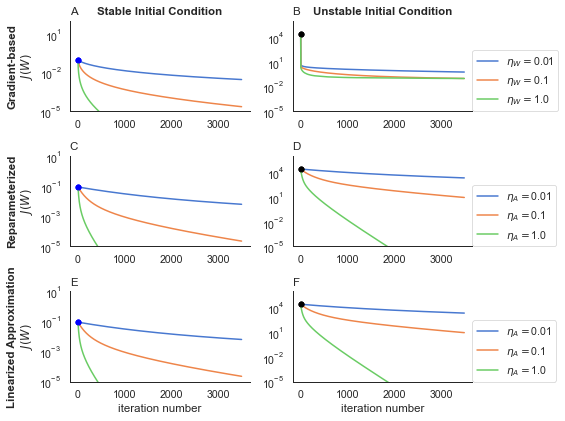

In [17]:
sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
plt.subplots(figsize=(8,6))

# Number of iterations to do grad descent
niterations = int(1000*3.5)
# To find solutions near W_target, take W_init=w[0]*W1 + (1-w[0])*W0
W_init = w[100-5]*W1 + W0
W = W_init

# Learning rate
eta_W = np.array([0.01, 0.1, 1])

# initialized the loss
losses = np.zeros((len(eta_W), niterations+1))
losses[:, 0] = W_nd_Costfun(W, G_nd, X_nd, r_hat_nd)

startW =tm() # time stamped
# sns.set(context='notebook',style='white',font_scale=1.1)
# sns.set_style("ticks")
# plt.figure(figsize = (5,3))

plt.subplot(3,2,1)
x = np.arange(0,niterations+1,1)
for i in range(len(eta_W)): 
    W = W_init
    for j in range(niterations):
        A = inv(invG_nd - W) # for convenience
        dJdW = -(2/m)*A.T@(A@X_nd-r_hat_nd)@((A@X_nd).T) # direct gradient descent updating rule
        W = W+eta_W[i]*dJdW
        losses[i, j+1]=W_nd_Costfun(W, G_nd, X_nd, r_hat_nd)

    y = losses[i,:]

    plt.ylim(ymin = 1e-5, ymax = 1e2)
    plt.yscale('log')
    plt.plot(x,y,label= r'$\eta_W = $' +  str(eta_W[i]))
    plt.plot(w[100-5], W_nd_Costfun((w[100-5]*W1 + W0), G_nd, X_nd, r_hat_nd), 'o', color = "blue")
      
#     ax = plt.gca()
#     ax.tick_params(axis='y', which='minor')
#     ax.set_yticks(np.round(np.arange(0.01*1e-6, 0.51, 0.1),3))
#     ax.set_yticklabels(np.round(np.arange(0.01*1e-6, 0.51, 0.1),3))

    plt.title('A',loc='left')
#     plt.xlabel('iteration number')
    plt.ylabel('Gradient-based'
               '\n'
              '$J(W)$', weight='bold')
    plt.title('Stable Initial Condition', weight='bold')
sns.despine()
# plt.axhline(y=W_nd_Costfun(W_star_try, G_nd, X_nd, r_hat_nd), color='red', linestyle='--', label= r'$J(W^*)$')

# plt.legend(bbox_to_anchor=(0.8,0.5), loc="center", fontsize = "x-small")
# plt.tight_layout()
# plt.savefig('./Figures/Fig4overA.eps',bbox_inches="tight")

stopW = tm()
print("Time to generate gradient descent: %.2f sec." %(stopW-startW) )
# plt.show()

###########################################################################


W_init2 = w[-(100-50)]*W1 + W0
W2 = W_init2

# initialized the loss
losses2 = np.zeros((len(eta_W), niterations+1))
losses2[:, 0] = W_nd_Costfun(W2, G_nd, X_nd, r_hat_nd)

startW =tm() # time stamped
# sns.set(context='notebook',style='white',font_scale=1.1)
# sns.set_style("ticks")
# plt.figure(figsize = (5,3))
plt.subplot(3,2,2)
x = np.arange(0,niterations+1,1)
for i in range(len(eta_W)): 
    W2 = W_init2
    for j in range(niterations):
        A2 = inv(invG_nd - W2)
        dJdW2 = -(2/m)*A2.T@(A2@X_nd-r_hat_nd)@((A2@X_nd).T)
        W2 = W2+eta_W[i]*dJdW2
        losses2[i, j+1]=W_nd_Costfun(W2,G_nd, X_nd, r_hat_nd)

    y2 = losses2[i,:]
    plt.ylim(ymin = 1e-5, ymax = 1e6)
    
    plt.plot(x,y2,label= r'$\eta_W = $' +  str(eta_W[i]))
    plt.plot(w[-(100-50)], W_nd_Costfun((w[-(100-50)]*W1 + W0), G_nd, X_nd, r_hat_nd), 'o', color = "black")
    plt.yscale('log')
    
    sns.despine()    
    plt.title('B',loc='left')
#     plt.xlabel('iteration number')
#     plt.ylabel('cost, $J(W)$')
    plt.title('Unstable Initial Condition', weight='bold')
plt.legend(loc=[1.0,0])
sns.despine()
# plt.axhline(y=W_nd_Costfun(W_star_try, G_nd, X_nd, r_hat_nd), color='red', linestyle='--', label= r'$J(W^*)$')
# plt.legend(bbox_to_anchor=(0.8,0.5), loc="center", fontsize = "x-small")
# plt.tight_layout()
# plt.savefig('./Figures/Fig4overB.eps',bbox_inches="tight")
stopW = tm()
print("Time to generate gradient descent: %.2f sec." %(stopW-startW) )



###########################################################################

# Number of iterations to do grad descent
niterations = int(1000*3.5)
W_init = w[100-5]*W1 + W0
W = W_init
A = inv(invG_nd - W)
# Learning rate
eta_A = np.array([0.01, 0.1, 1])

losses = np.zeros((len(eta_A), niterations+1))
losses[:, 0] = A_nd_Costfun(A, X_nd, r_hat_nd)

startW =tm() # time stamped
# sns.set(context='notebook',style='white',font_scale=1.1)
# sns.set_style("ticks")
# plt.figure(figsize = (5,3))
plt.subplot(3,2,3)
x = np.arange(0,niterations+1,1)
for i in range(len(eta_A)):  
    W = W_init
    A = inv(invG_nd - W)
    for j in range(niterations):        
        dJdA = -(2/m)*(A@X_nd - r_hat_nd)@X_nd.T
        A = A + eta_A[i]*dJdA
        dJdW = invG_nd-W-inv(inv(invG_nd-W)-(2/m)*eta_A[i]*(A@X_nd-r_hat_nd)@(X_nd).T)
        W = W + dJdW
        A = inv(invG_nd - W)
        losses[:, j+1] = A_nd_Costfun(A, X_nd, r_hat_nd)

    y = losses[i,:] 
    plt.yscale('log')
    plt.plot(x,y,label= r'$\eta_A = $' +  str(eta_A[i]))
    plt.plot(w[100-5], W_nd_Costfun((w[100-5]*W1 + W0),G_nd, X_nd, r_hat_nd), 'o', color = "blue")
    plt.title('C',loc='left')
#     plt.xlabel('iteration number')
    plt.ylabel('Reparameterized'
               '\n'
               '$J(W)$', weight='bold')
    plt.ylim(ymin = 1e-5, ymax = 1e1)
#     plt.title("reparameterized")
    
# plt.axhline(y=A_nd_Costfun(A_star_psudo, X_nd, r_hat_nd), color='red', linestyle='--', label= r'$J(W^*)$')

# plt.legend(bbox_to_anchor=(0.8,0.5), loc="center", fontsize = "x-small")
# plt.tight_layout()
# plt.savefig('./Figures/Fig4overC.eps',bbox_inches="tight")
sns.despine()
stopW = tm()
print("Time to generate gradient descent: %.2f sec." %(stopW-startW) )
# plt.show()


###########################################################################

# Number of iterations to do grad descent
niterations = int(1000*3.5)

W_init2 = w[-(100-50)]*W1 + W0
W2 = W_init2
A2 = inv(invG_nd - W2)

# Learning rate
# eta_A = np.array([0.01, 0.1, 1, 10])
losses2 = np.zeros((len(eta_A), niterations+1))
losses2[:, 0] = A_nd_Costfun(A2, X_nd, r_hat_nd)

startW =tm() # time stamped
# sns.set(context='notebook',style='white',font_scale=1.1)
# sns.set_style("ticks")
# plt.figure(figsize = (5,3))
plt.subplot(3,2,4)
x = np.arange(0,niterations+1,1)
for i in range(len(eta_A)):  
    W2 = W_init2
    A2 = inv(invG_nd - W2)
    for j in range(niterations):
        dJdA2 = -(2/m)*(A2@X_nd - r_hat_nd)@X_nd.T
        A2 = A2 + eta_A[i]*dJdA2
        dJdW2 = invG_nd-W2-inv(inv(invG_nd-W2)-(2/m)*eta_A[i]*(A2@X_nd-r_hat_nd)@(X_nd).T)
        W2 = W2 + dJdW2
        A2 = inv(invG_nd - W2)
        losses2[:, j+1] = A_nd_Costfun(A2, X_nd, r_hat_nd)

    y2 = losses2[i,:]    
    plt.yscale('log')
    plt.plot(x,y2,label= r'$\eta_A = $' +  str(eta_A[i]))
    plt.plot(w[-(100-50)], W_nd_Costfun((w[-(100-50)]*W1 + W0), G_nd, X_nd, r_hat_nd), 'o', color = "black")
    plt.title('D',loc='left')
#     plt.xlabel('iteration number')
#     plt.ylabel('cost, $J$')
    plt.ylim(ymin = 1e-5, ymax = 1e6)
#     plt.title("reparameterized")
# plt.axhline(y=A_nd_Costfun(A_star_psudo, X_nd, r_hat_nd), color='red', linestyle='--', label= r'$J(W^*)$')
# plt.legend(bbox_to_anchor=(0.8,0.5), loc="center", fontsize = "x-small")
plt.legend(loc=[1.0,0])
# plt.tight_layout()
# plt.savefig('./Figures/Fig4overD.eps',bbox_inches="tight")
sns.despine()
stopW = tm()
print("Time to generate gradient descent: %.2f sec." %(stopW-startW) )

# plt.show()


###########################################################################

# Number of iterations to do grad descent
niterations = int(1000*3.5)

# To find solutions near W_target, take W_init=w[0]*W1 + (1-w[0])*W0
W_init = w[100-5]*W1 + W0
W = W_init

# Learning rate
# eta_A = eta_A = np.array([0.01, 0.1, 1, 10])# 30 blow up
losses = np.zeros((len(eta_A), niterations+1))
losses[:, 0] = W_nd_Costfun(W,G_nd, X_nd,r_hat_nd)

startW =tm() # time stamped
# sns.set(context='notebook',style='white',font_scale=1.1)
# sns.set_style("ticks")
# plt.figure(figsize = (5,3))
plt.subplot(3,2,5)
x = np.arange(0,niterations+1,1)
for i in range(len(eta_A)):
    W = W_init
    for j in range(niterations):
#         A = inv(invG_nd - W)
        dJdW = -(2/m)*eta_A[i]*(X_nd-(invG_nd-W)@r_hat_nd)@X_nd.T@(invG_nd-W)
        W = W + dJdW
        losses[i, j+1]=W_nd_Costfun(W, G_nd, X_nd, r_hat_nd)
    y = losses[i,:]
    
    plt.ylim(ymin = 1e-5, ymax = 1e1)
    plt.yscale('log')
    plt.plot(x,y,label= r'$\eta_A = $' +  str(eta_A[i]))
    plt.plot(w[100-5], W_nd_Costfun((w[100-5]*W1 + W0), G_nd, X_nd, r_hat_nd), 'o', color = "blue")

    plt.title('E',loc='left')
    plt.xlabel('iteration number')
    plt.ylabel('Linearized Approximation'
              "\n" 
              '$J(W)$', weight='bold')
# plt.axhline(y=W_nd_Costfun(W_star_try, G_nd, X_nd, r_hat_nd), color='red', linestyle='--', label= r'$J(W^*)$')
# plt.legend(bbox_to_anchor=(0.8,0.5), loc="center", fontsize = "x-small")
# plt.tight_layout()
# plt.savefig('./Figures/Fig4overE.eps',bbox_inches="tight")
sns.despine()
stopW = tm()
print("Time to generate gradient descent: %.2f sec." %(stopW-startW) )

# plt.show()



###########################################################################

# Number of iterations to do grad descent
niterations = int(1000*3.5)
# To find solutions near W_target, take W_init=w[0]*W1 + (1-w[0])*W0
W_init = w[-(100-50)]*W1 + W0
W = W_init
# Learning rate
# eta_A = eta_A = np.array([0.01, 0.1, 1, 10])# 30 blow up

losses = np.zeros((len(eta_A), niterations+1))
losses[:, 0] = W_nd_Costfun(W,G_nd, X_nd,r_hat_nd)

startW =tm() # time stamped
# sns.set(context='notebook',style='white',font_scale=1.1)
# sns.set_style("ticks")
# plt.figure(figsize = (5,3))
plt.subplot(3,2,6)
x = np.arange(0,niterations+1,1)
for i in range(len(eta_A)):  
    W = W_init
    for j in range(niterations):
        #A = inv(invG_nd - W)
        dJdW = -(2/m)*eta_A[i]*(X_nd-(invG_nd-W)@r_hat_nd)@X_nd.T@(invG_nd-W)
        W = W + dJdW
        losses[i, j+1]=W_nd_Costfun(W, G_nd, X_nd, r_hat_nd)
    y = losses[i,:]
    plt.ylim(ymin = 1e-5, ymax = 1e6)
    
    plt.yscale('log')
    plt.plot(x,y,label= r'$\eta_A = $' +  str(eta_A[i]))
    plt.plot(w[-(100-50)], W_nd_Costfun((w[-(100-50)]*W1 + W0), G_nd, X_nd, r_hat_nd), 'o', color = "black")

    plt.title('F',loc='left')
    plt.xlabel('iteration number')
#     plt.ylabel('cost, $J(w)$')
#     plt.title("linearized reparameterized")
    
# plt.axhline(y=A_nd_Costfun(A_star_psudo, X_nd, r_hat_nd), color='red', linestyle='--', label= r'$J(W^*)$')
# plt.legend(bbox_to_anchor=(0.8,0.5), loc="center", fontsize = "x-small")
plt.legend(loc=[1.0,0])
sns.despine()
plt.tight_layout()
# plt.savefig('./Figures/Fig4overF.eps',bbox_inches="tight")

stopW = tm()
print("Time to generate gradient descent: %.2f sec." %(stopW-startW) )

plt.savefig('./Figures/LinearNDdW123.pdf')


Time to generate gradient descent: 102.94 sec.
Time to generate gradient descent: 61.98 sec.


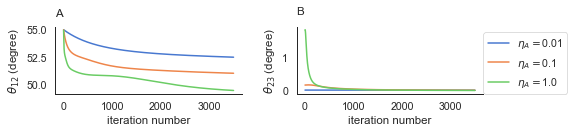

In [18]:
sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
plt.subplots(figsize=(8,2))

# Number of iterations to do grad descent
niterations = int(1000*3.5)

W_init = w[100-5]*W1 + W0
W = W_init
r = np.linalg.solve((invG_nd - W), X_nd)

startW =tm() # time stamped
angles = np.zeros((len(eta_A), niterations))
plt.subplot(1,2,1)
x = np.arange(0,niterations,1)
for i in range(len(eta_A)):  
    W = W_init
    for j in range(niterations):   
        dJdW2 = -invG_nd+W+inv(inv(invG_nd-W)-(2/m)*eta_A[i]*(r-r_hat_nd)@(X_nd).T)
        dJdW1 = (inv(invG_nd - W)).T@(r-r_hat_nd)@(r.T)
        r = np.linalg.solve((invG_nd - W), X_nd)
        # then compute angle
        cos_of_angle = np.sum(dJdW1*dJdW2)/np.sqrt(np.sum(dJdW1*dJdW1)*np.sum(dJdW2*dJdW2))
        angles[i,j] = np.arccos(np.clip(cos_of_angle,-1,1))  * 180/np.pi
        W = W - dJdW2
 ######################################### Angle plot A #########################################         
    y = angles[i,:]
    plt.plot(x[1:],y[1:],label= r'$\eta_A = $' +  str(eta_A[i]))    
    plt.title('A',loc='left',pad=10)
    plt.ylabel(r'$\theta_{12}$ (degree)')
    plt.xlabel('iteration number')
sns.despine()    
# plt.legend(bbox_to_anchor=(0.8,0.5), loc="center", fontsize = "x-small")
# plt.tight_layout()
# plt.savefig('./Figures/FigDegreeA.eps',bbox_inches="tight")
stopW = tm()
print("Time to generate gradient descent: %.2f sec." %(stopW-startW) )
# plt.show()




# Number of iterations to do grad descent
niterations = int(1000*3.5)

# To find solutions near W_target, take W_init=w[0]*W1 + (1-w[0])*W0
W_init = w[100-5]*W1 + W0
W = W_init
startW =tm() # time stamped
angles = np.zeros((len(eta_A), niterations))
cor = np.zeros((len(eta_A), niterations))
x = np.arange(0,niterations,1)
plt.subplot(1,2,2)
for i in range(len(eta_A)):  
    W = W_init
    for j in range(niterations):
        # first compute dW2 for the update
        dJdW2 = -invG_nd+W+inv(inv(invG_nd-W)-(2/m)*eta_A[i]*(r-r_hat_nd)@(X_nd).T)
        dJdW3 = (2/m)*eta_A[i]*(X_nd-(invG_nd-W)@r_hat_nd)@X_nd.T@(invG_nd-W)
        r = np.linalg.solve((invG_nd - W), X_nd)
        
        # then compute angle
        cos_of_angle = np.sum(dJdW2*dJdW3)/np.sqrt(np.sum(dJdW2*dJdW2)*np.sum(dJdW3*dJdW3))
        angles[i,j] = np.arccos(np.clip(cos_of_angle,-1,1))  * 180/np.pi
        W = W -dJdW3
        
        # now compute dW1

######################################### angle plot E  #########################################        
    y = angles[i,:]
    plt.plot(x[5:],y[5:],label= r'$\eta_A = $' +  str(eta_A[i]))

    
    plt.title('B',loc='left',pad=12)
    plt.xlabel('iteration number')
    plt.ylabel(r'$\theta_{23}$ (degree)')

# plt.legend(bbox_to_anchor=(0.8,0.5), loc="center", fontsize = "x-small")
plt.legend(loc=[1.0,0])
sns.despine()
plt.tight_layout()
# plt.savefig('./Figures/FigDegreeC.eps',bbox_inches="tight")
stopW = tm()
print("Time to generate gradient descent: %.2f sec." %(stopW-startW) )  


plt.savefig('./Figures/LinearNDangle.pdf')